# Setup

In [2]:
# settings
%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline

# download data from s3
# wkdir = '/home/ubuntu/data/DL20181011_melanocyte_test_data'
# s3dir = 'daniel.le-work/MEL_project'
# for file in ['primary_mel_rawdata_181011.csv',
#              'primary_mel_metadata_181011.csv',
#              'DL20181106_bsc_metadata.csv',
#              'DL20181107_metadata_update.csv']:
#     ! aws s3 cp --quiet s3://{s3dir}/{file} {wkdir}/

# read annotation data
anno = pd.read_csv('s3://daniel.le-work/MEL_project/primary_mel_metadata_181011.csv', index_col=0)
anno = anno.loc[:, ['nGenes', 'nReads', 'well', 'plate', 'patient_id']]
anno = anno.rename(columns={'plate':'plate_barcode'})
anno['cell_name'] = ['{}_{}'.format(x,y) for x,y in zip(anno['well'], anno['plate_barcode'])]

# metadata update: 11-07-2018
plate_df = pd.read_csv('s3://daniel.le-work/MEL_project/DL20181107_metadata_update.csv')
plate_df = plate_df.loc[~plate_df['plate_barcode'].isnull(),:] # remove any row without plate barcode
plate_df = plate_df.loc[:, ['plate_barcode', 'patient_id', 'sample_color', 'age', 
                            'age_bin', 'sex','race', 'general_location', 'anatomical_location']]

# update metadata with merge
merged_anno = pd.merge(anno, plate_df, 'left', ['plate_barcode', 'patient_id'])

# append bsc metadata to anno
bsc = pd.read_csv('s3://daniel.le-work/MEL_project/DL20181106_bsc_metadata.csv')
merged_anno = pd.merge(merged_anno,bsc,'left',['well','plate_barcode'])
merged_anno = merged_anno.set_index('cell_name')

# read raw data (expression data) to pandas df
pre_adata = pd.read_csv('s3://daniel.le-work/MEL_project/primary_mel_rawdata_181011.csv', index_col=0)
pre_adata.columns = merged_anno.index.tolist()
pre_adata = pre_adata.rename_axis('gene_name')

# markers
markers = ['PMEL','KRT1','KRT5','KRT10','TYR','MITF']

scanpy version: 1.3.3


# Ingest data protocol
- Raw data and annotation CSV provided by Ashley Maynard

In [3]:
raw_adata = create_adata(pre_adata)
raw_adata.var['ribo'] = raw_adata.var_names.str.startswith(('RPL','RPS'))
raw_adata.var['ercc'] = np.array([True if 'ERCC' in x else False for x in raw_adata.var_names.tolist()])
sc.pp.calculate_qc_metrics(raw_adata, feature_controls=['ribo','ercc'], inplace=True)
anno_dict = {'age':'age',
             'age_bin':'age_bin',
             'plate':'plate_barcode',
             'general_location':'general_location',
             'anatomical_location':'anatomical_location',
             'race':'race',
             'sex':'sex',
             'color':'sample_color',
             'patient':'patient_id',
             'bsc': 'bsc_a'}
append_anno(raw_adata, merged_anno, anno_dict)
append_markers(raw_adata, gene_markers=markers)
technical_filters(raw_adata)
# raw_adata = remove_ercc(raw_adata) 
raw_adata.raw = sc.pp.log1p(raw_adata, copy=True) # freeze raw state

Ingest raw data...
	Cells: 4356, Genes: 26485
Append annotations...
	Cells: 4356, Genes: 26485
Append marker gene expresssion...
Remove low-quality cells/genes...
	Initial:
	Cells: 4356, Genes: 26485
	Result:
	Cells: 4311, Genes: 23196


# All-cells analysis

Process expression data...
	Initial:
	Cells: 4311, Genes: 23196
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 12901
	Result:
	Cells: 4311, Genes: 10295
Principle component analysis...


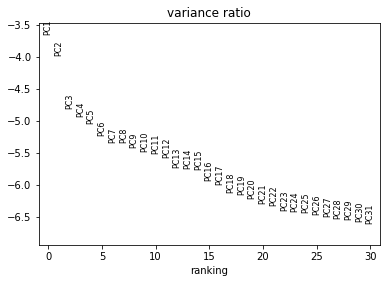

principle_components(num_pcs): 16
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


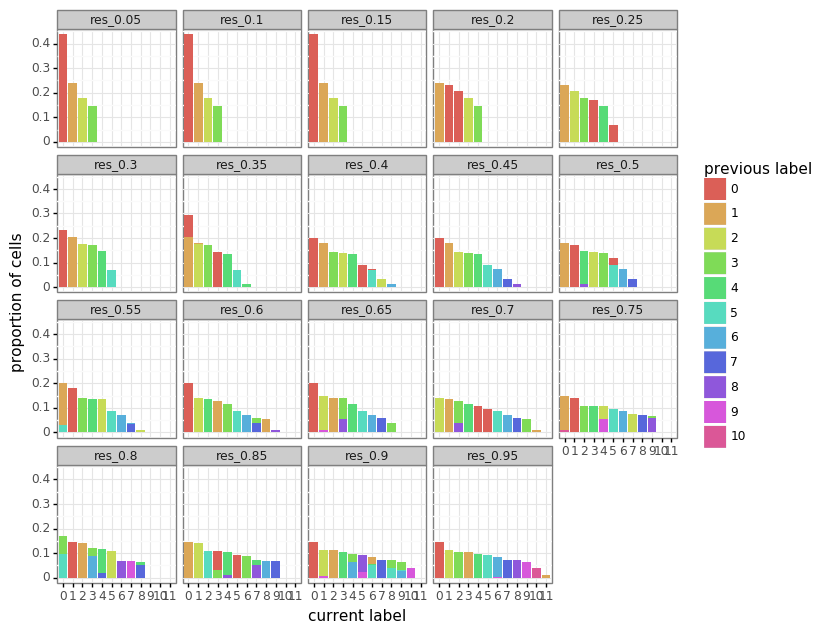

<ggplot: (-9223363293805117289)>


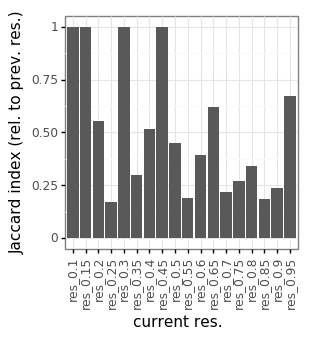

<ggplot: (-9223363293805166087)>
resolution(res): 0.25


... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical


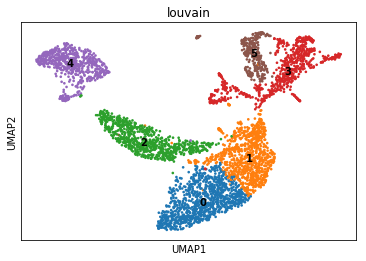

In [342]:
full_adata = process_adata(raw_adata)
pca_adata(full_adata, num_pcs=16)
umap_adata(full_adata, res=0.25)

# Classify MEL vs KRT
- Manual classification based on marker gene expression

In [4]:
# classify in raw adata
input_adata = full_adata

MEL_int = [0,1,2,4]
KRT_int = [x for x in range(len(input_adata.obs['louvain'].cat.categories)) if x not in MEL_int]
type_dict = {'KRT':[str(x) for x in KRT_int],
             'MEL':[str(x) for x in MEL_int]}
    
classify_type(raw_adata, input_adata, 'louvain', type_dict, 'class_1')

# Adult MEL only re-cluster

key = age_bin, value = 60_69, matched = 1225
key = age_bin, value = 30_39, matched = 126
key = age_bin, value = 20_29, matched = 326
key = age_bin, value = 50_59, matched = 667
key = age_bin, value = 80_89, matched = 103
key = age_bin, value = 40_49, matched = 168
key = class_1, value = MEL, matched = 3281
	Cells: 1884, Genes: 23196
Process expression data...
	Initial:
	Cells: 1884, Genes: 23196
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 13065
	Result:
	Cells: 1884, Genes: 10131
Principle component analysis...


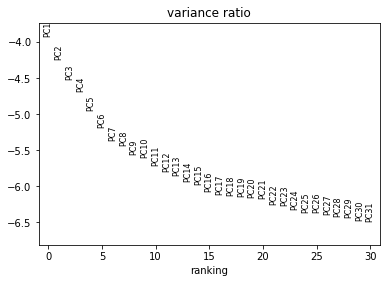

principle_components(num_pcs): 7
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


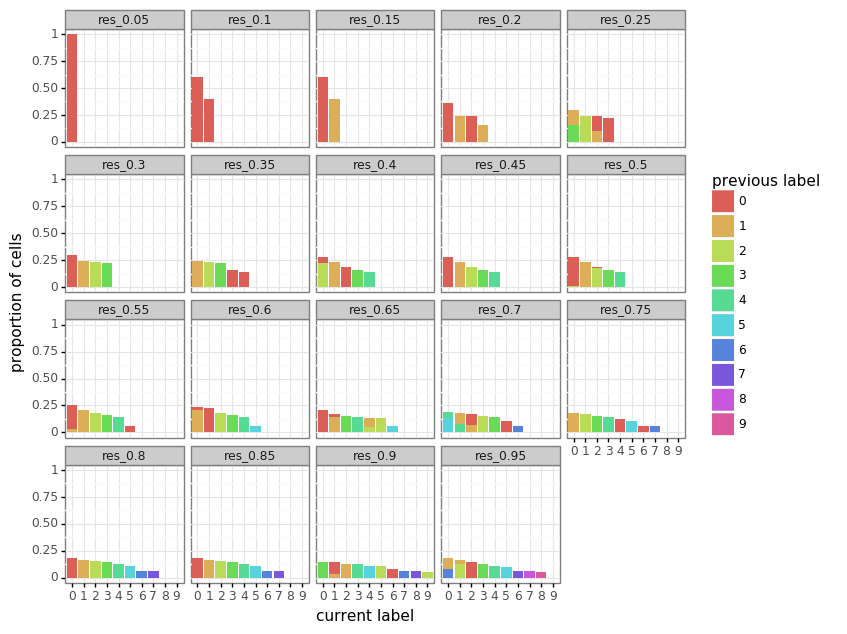

<ggplot: (-9223363263881990284)>


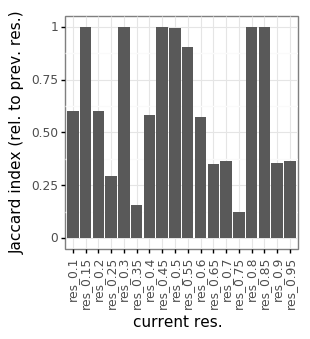

<ggplot: (8772979262952)>
resolution(res): 0.1


... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical


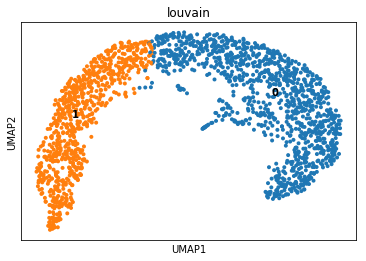

In [5]:
# remove non-Adult bins
age_bins = raw_adata.obs['age_bin'].unique()
for feat in ['FET_12WK','NEO']:
    age_bins = age_bins[age_bins != feat]

feature_dict = {'age_bin':age_bins.tolist(), 'class_1':['MEL']}
adata_subset1 = subset_adata_v3(raw_adata,feature_dict)
adata_subset1 = process_adata(adata_subset1)
pca_adata(adata_subset1, num_pcs=7)
umap_adata(adata_subset1, res=0.1)

In [6]:
# input_adata = adata_subset1
# methods=['wilcoxon','t-test_overestim_var']
# groupby='louvain'
# rank_df = rank_genes(input_adata, 
#                      methods=methods,
#                      groupby=groupby)

# # inner join 2 methods 
# input_rank = rank_df
# joined_test = pd.merge(input_rank[input_rank['method'] == methods[0]]
#                        .reset_index()
#                        .rename(columns={'index':'{}_rank'.format(methods[0])})
#                        .drop(columns='method', axis=1),
#                      input_rank[input_rank['method'] == methods[1]]
#                        .reset_index()
#                        .rename(columns={'index':'{}_rank'.format(methods[1])})
#                        .loc[:,['gene',groupby,'{}_rank'.format(methods[1])]],
#                      'inner',
#                      ['gene',groupby])

# # push to s3
# push_rank (rank_df, 'AdtMel_includeOutliers_full', wkdir, s3dir)
# push_rank (joined_test, 'AdtMel_includeOutliers_joined', wkdir, s3dir)

# Isolating general variance explained by removing highly leveraged cells in PCA
- Outlier detection in each PC outside ad hoc IQR * scalar threshold

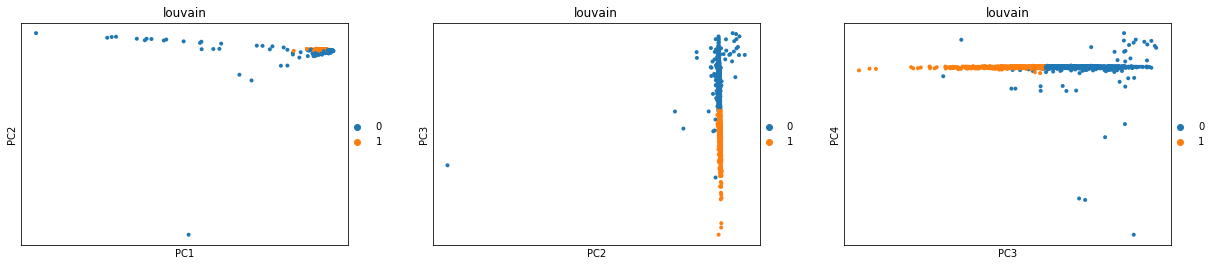

Filtered cells:  116


... storing 'outliers' as categorical


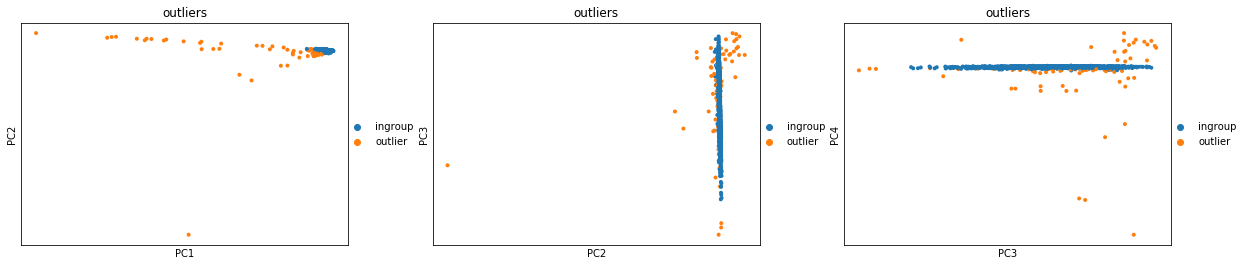

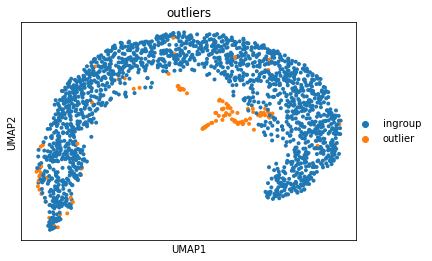

... storing 'outliers' as categorical


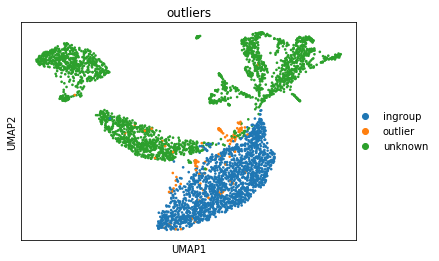

In [7]:
# initial PC coordinates
sc.pl.pca(adata_subset1, components=['1,2', '2,3','3,4'], color=['louvain'])

# cull cells using Tukey outlier threshold
df = pd.DataFrame(adata_subset1.obsm['X_pca'])
df.columns = ['PC_{}'.format(x) for x in range(50)]

omit_names = []
for pc in df.columns:
#     print(len(set(omit_names)))
    Q1 = df[pc].quantile(0.25)
    Q3 = df[pc].quantile(0.75)
    IQR = Q3 - Q1
    threshold=7

    bool_idx = [True if ((Q1 - threshold * IQR) <= x <= (Q3 + threshold * IQR)) else False for x in df[pc]]
    filtered = df[bool_idx]
#     print('Filtered cells: ', len(df)-len(filtered))
    
    omit_names = omit_names + adata_subset1.obs[[not x for x in bool_idx]].index.tolist()

print('Filtered cells: ', len(set(omit_names)))
test = raw_adata[[x for x in raw_adata.obs.index if x not in set(omit_names)]]

# check where the outliers lie in original projection
input_adata = adata_subset1
input_adata.obs['outliers'] = ['outlier' if x in set(omit_names) else 'ingroup' for x in input_adata.obs.index]

# outliers among adt-mels
sc.pl.pca(adata_subset1, components=['1,2', '2,3','3,4'], color=['outliers'])
sc.pl.umap(input_adata, color=['outliers'], cmap='magma')

# outliers on all-cells projection
input_adata = adata_subset1

type_dict = {'ingroup':['ingroup'],
             'outlier':['outlier']}
    
classify_type(full_adata, input_adata, 'outliers', type_dict, 'outliers')

sc.pl.umap(full_adata, color=['outliers'])

# Rank genes between in and out groups

In [8]:
# input_adata = adata_subset1
# methods=['wilcoxon','t-test_overestim_var']
# groupby='outliers'
# rank_df = rank_genes(input_adata, 
#                      methods=methods,
#                      groupby=groupby)

# # inner join 2 methods 
# input_rank = rank_df
# joined_test = pd.merge(input_rank[input_rank['method'] == methods[0]]
#                        .reset_index()
#                        .rename(columns={'index':'{}_rank'.format(methods[0])})
#                        .drop(columns='method', axis=1),
#                      input_rank[input_rank['method'] == methods[1]]
#                        .reset_index()
#                        .rename(columns={'index':'{}_rank'.format(methods[1])})
#                        .loc[:,['gene',groupby,'{}_rank'.format(methods[1])]],
#                      'inner',
#                      ['gene',groupby])

# # push to s3
# push_rank (rank_df, 'AdtMel_outliers_full', wkdir, s3dir)
# push_rank (joined_test, 'AdtMel_outliers_joined', wkdir, s3dir)

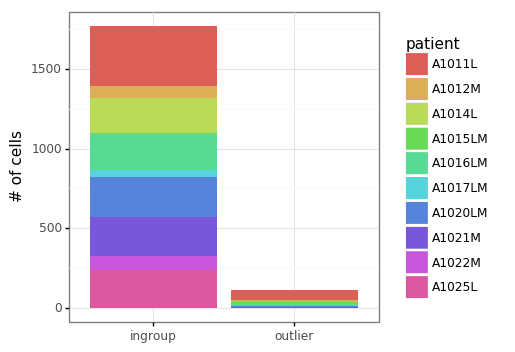

<ggplot: (-9223363263880378501)>


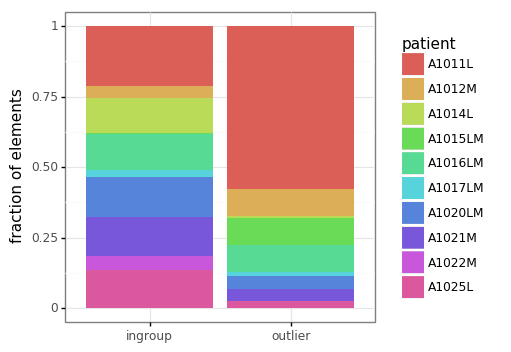

<ggplot: (8772974451997)>


In [9]:
# outlier occupancy by patient 
occupancy(adata_subset1, 'patient', 'outliers')

# Recluster sans outliers

key = age_bin, value = 60_69, matched = 1225
key = age_bin, value = 30_39, matched = 126
key = age_bin, value = 20_29, matched = 326
key = age_bin, value = 50_59, matched = 667
key = age_bin, value = 80_89, matched = 103
key = age_bin, value = 40_49, matched = 168
key = class_1, value = MEL, matched = 3281
key = class_2, value = ingroup, matched = 1768
	Cells: 1768, Genes: 23196
Process expression data...
	Initial:
	Cells: 1768, Genes: 23196
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 13452
	Result:
	Cells: 1768, Genes: 9744
Principle component analysis...


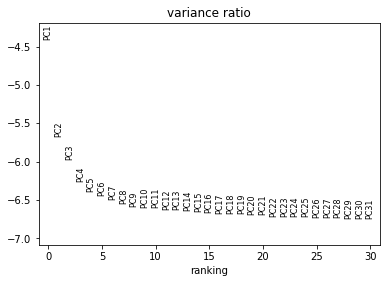

principle_components(num_pcs): 30
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


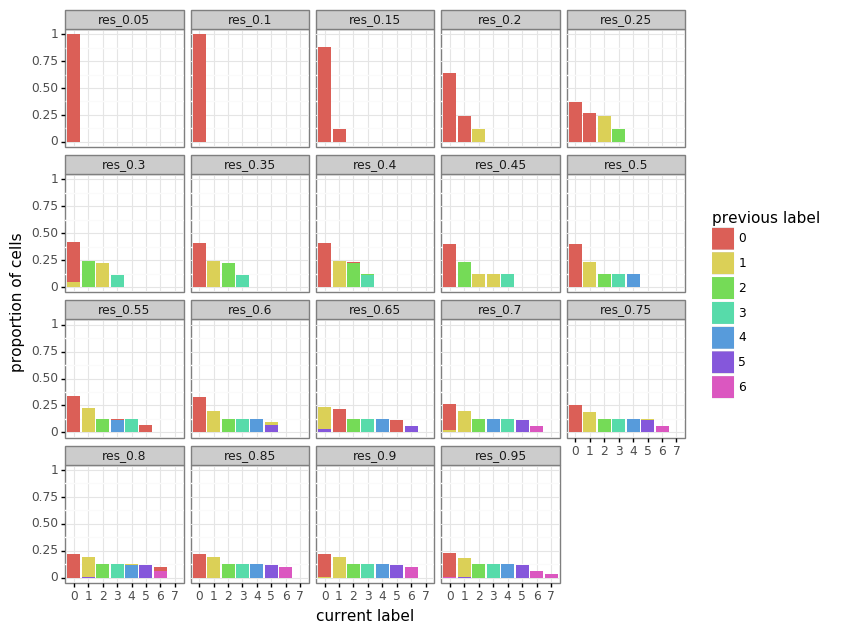

<ggplot: (-9223363263879820982)>


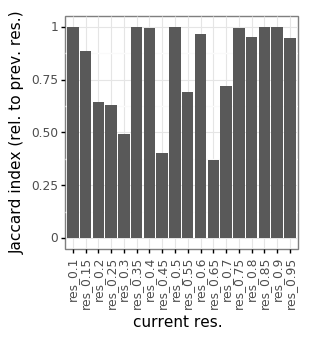

<ggplot: (-9223363263878604365)>
resolution(res): 0.5


... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical
... storing 'class_2' as categorical


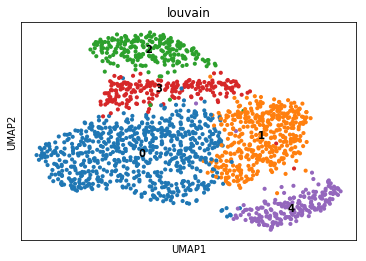

In [10]:
# classify
input_adata = adata_subset1

type_dict = {'ingroup':['ingroup'],
             'outlier':['outlier']}
    
classify_type(raw_adata, input_adata, 'outliers', type_dict, 'class_2')

# recluster
feature_dict = {'age_bin':age_bins.tolist(), 'class_1':['MEL'], 'class_2':['ingroup']}
adata_subset2 = subset_adata_v3(raw_adata, feature_dict)
adata_subset2 = process_adata(adata_subset2)
pca_adata(adata_subset2, num_pcs=30)
umap_adata(adata_subset2, res=.5)

In [11]:
# # rank genes adult mels sans outliers
# input_adata = adata_subset2
# groupby='louvain'
# methods=['wilcoxon','t-test_overestim_var']
# rank_df = rank_genes(input_adata, 
#                              groupby=groupby, 
#                              methods=methods)

# # inner join 2 methods 
# input_rank = rank_df
# joined_test = pd.merge(input_rank[input_rank['method'] == methods[0]]
#                        .reset_index()
#                        .rename(columns={'index':'{}_rank'.format(methods[0])})
#                        .drop(columns='method', axis=1),
#                      input_rank[input_rank['method'] == methods[1]]
#                        .reset_index()
#                        .rename(columns={'index':'{}_rank'.format(methods[1])})
#                        .loc[:,['gene',groupby,'{}_rank'.format(methods[1])]],
#                      'inner',
#                      ['gene',groupby])

# # push to s3
# push_rank (rank_df, 'AdtMel_sansOutliers_full', wkdir, s3dir)
# push_rank (joined_test, 'AdtMel_sansOutliers_joined', wkdir, s3dir)

# Cluster occupancy by patient 

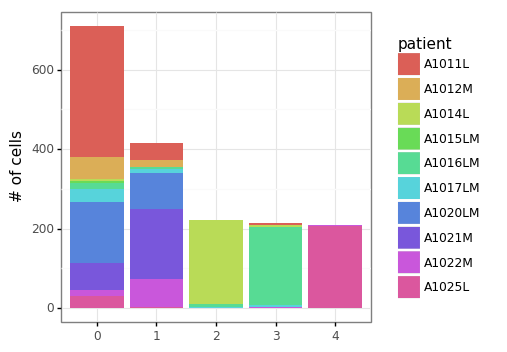

<ggplot: (8772979659093)>


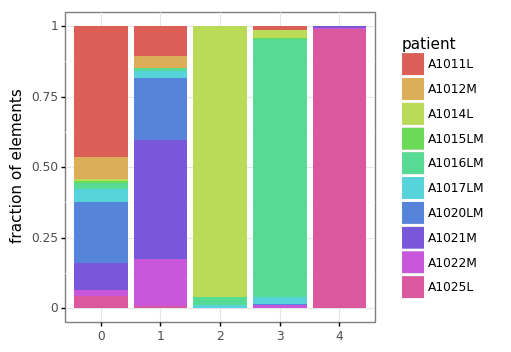

<ggplot: (8772974372861)>


In [12]:
# cluster occupancy by patient 
occupancy(adata_subset2, 'patient', 'louvain')

key = age_bin, value = 60_69, matched = 1225
key = age_bin, value = 30_39, matched = 126
key = age_bin, value = 20_29, matched = 326
key = age_bin, value = 50_59, matched = 667
key = age_bin, value = 80_89, matched = 103
key = age_bin, value = 40_49, matched = 168
key = class_1, value = MEL, matched = 3281
key = class_3, value = main, matched = 1125
	Cells: 1125, Genes: 23196
Process expression data...
	Initial:
	Cells: 1125, Genes: 23196
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 13973
	Result:
	Cells: 1125, Genes: 9223
Principle component analysis...


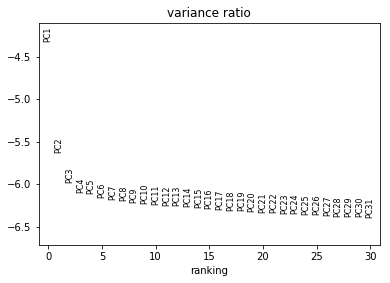

principle_components(num_pcs): 30
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


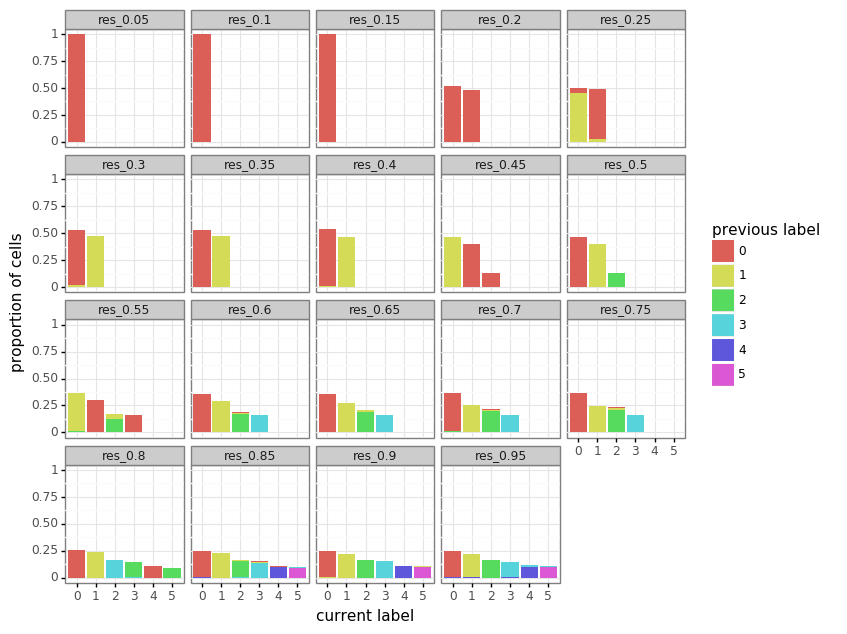

<ggplot: (8772974021440)>


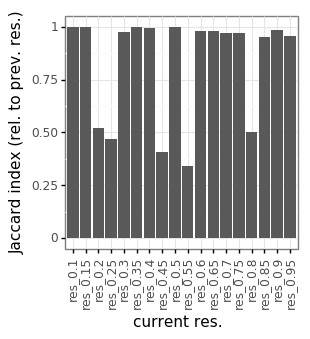

<ggplot: (8772979113371)>
resolution(res): 0.4


... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical
... storing 'class_2' as categorical
... storing 'class_3' as categorical


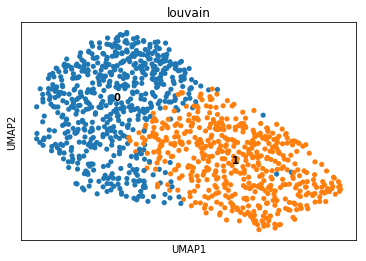

In [13]:
# classify
input_adata = adata_subset2

type_dict = {'main':['0','1'],
             'outer':['2','3','4']}
    
classify_type(raw_adata, input_adata, 'louvain', type_dict, 'class_3')

# recluster
feature_dict = {'age_bin':age_bins.tolist(), 
                'class_1':['MEL'], 
                'class_3':['main']}
adata_subset3 = subset_adata_v3(raw_adata, feature_dict)
adata_subset3 = process_adata(adata_subset3)
pca_adata(adata_subset3, num_pcs=30)
umap_adata(adata_subset3, res=.4)

# Arguments for technical variance that explains cluster sectors

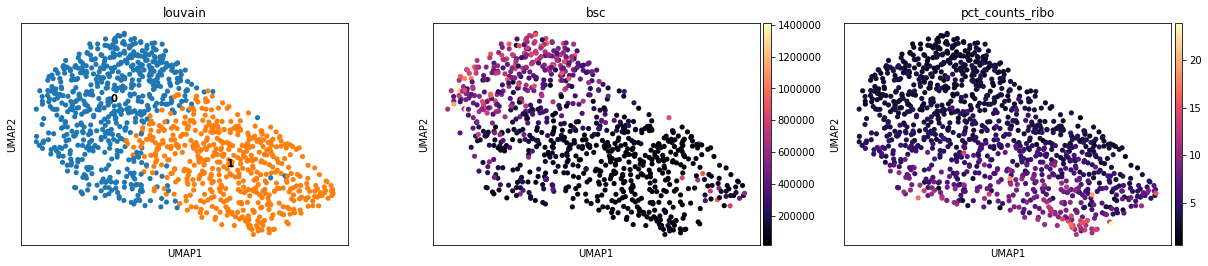

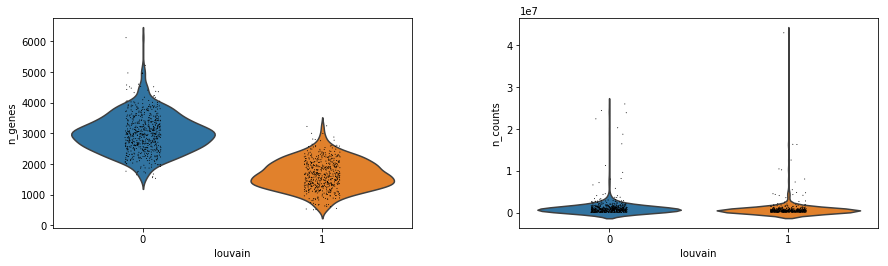

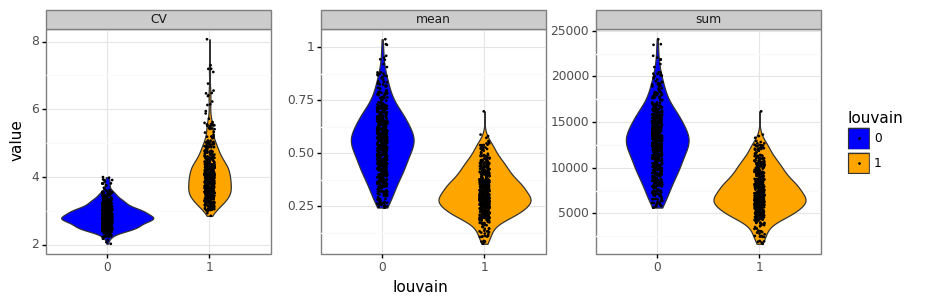

<ggplot: (8772979799037)>


In [14]:
# reverse color code
# adata_subset3.obs['louvain'] = ['0' if x == '1' else '1' if x == '0' else x for x in adata_subset3.obs['louvain']]
input_adata = adata_subset3

sc.pl.umap(input_adata, color=['louvain', 'bsc', 'pct_counts_ribo'], legend_loc='on data', cmap = 'magma')


# cell QC ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4758103/pdf/13059_2016_Article_888.pdf
# article indicates that n_genes does not generally explain low-quality cells
# authors suggest "Transcriptome Variance", which I interpret to be Coef of Var, as a good metric of quality

sc.pl.violin(input_adata, ['n_genes', 'n_counts'], groupby='louvain')

# fewer genes expressed in low-bsc segment


df = pd.DataFrame({'CV':variation(input_adata.raw.X.todense(), axis = 1),
                   'mean':np.mean(input_adata.raw.X.todense(), axis=1).ravel().tolist()[0],
                   'sum':np.sum(input_adata.raw.X.todense(), axis=1).ravel().tolist()[0],
                   'louvain':input_adata.obs['louvain'].tolist()})
df = pd.melt(df,id_vars='louvain')
df
colors=['blue','orange','green','red']
plotnine.options.figure_size = (10,7)
print(ggplot(df, aes('louvain','value', fill='louvain'))
      +theme_bw()
      +theme(aspect_ratio=1,
             panel_spacing_x=0.5)
      +geom_violin()
      +geom_jitter(width=0.05, size=0.1, color='black')
      +scale_fill_manual(values=colors)
      +facet_wrap('~variable', scales='free_y'))

# higher transcriptome variation and lower overall counts

In [15]:
# # rank genes adult mels sans outliers
# input_adata = adata_subset3
# groupby='louvain'
# methods=['wilcoxon','t-test_overestim_var']
# rank_df = rank_genes(input_adata, 
#                              groupby=groupby, 
#                              methods=methods)

# # inner join 2 methods 
# input_rank = rank_df
# joined_test = pd.merge(input_rank[input_rank['method'] == methods[0]]
#                        .reset_index()
#                        .rename(columns={'index':'{}_rank'.format(methods[0])})
#                        .drop(columns='method', axis=1),
#                      input_rank[input_rank['method'] == methods[1]]
#                        .reset_index()
#                        .rename(columns={'index':'{}_rank'.format(methods[1])})
#                        .loc[:,['gene',groupby,'{}_rank'.format(methods[1])]],
#                      'inner',
#                      ['gene',groupby])

# # push to s3
# push_rank (rank_df, 'AdtMel_sansOuterPatients_full', wkdir, s3dir)
# push_rank (joined_test, 'AdtMel_sansOuterPatients_joined', wkdir, s3dir)

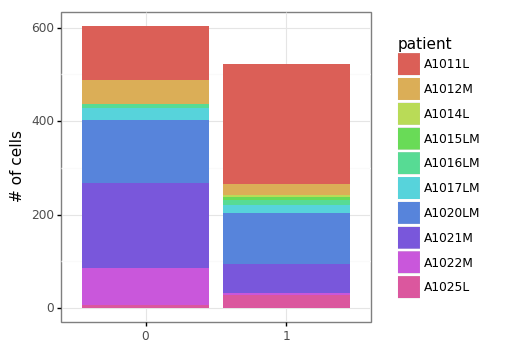

<ggplot: (8772973159144)>


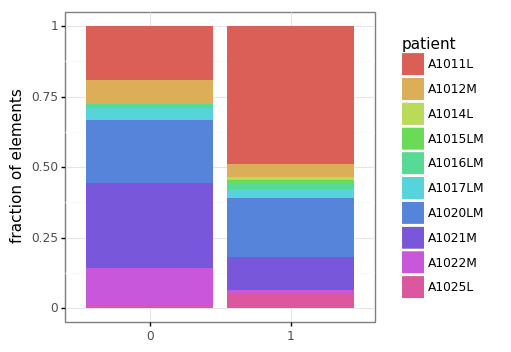

<ggplot: (8772973647031)>


In [16]:
# outlier occupancy by patient 
occupancy(adata_subset3, 'patient', 'louvain')

In [ ]:
# plot DE genes expression distribution
def gene_report(input_adata, input_DE, groupby, genelist=None):
    import math

    if not genelist:
        genelist = sorted(list(set(input_DE['gene'])))

    cats, casted_df = prepare_dataframe(input_adata, 
                                         genelist, 
                                         groupby=groupby)

    melt_df = pd.melt(casted_df.reset_index(), id_vars=groupby)

    plotnine.options.figure_size = (2,2)
    for gene in genelist:
        entry = input_DE[input_DE['gene'] == gene]
        print(gene)
        print(entry['function'].tolist()[0])
        plot_entry = melt_df[melt_df['variable'] == gene]
        plot_entry['cats'] = plot_entry[groupby].astype('category', 
                                                         ordered = True, 
                                                         categories = sorted(list(set(plot_entry[groupby])))[::-1])
        exp_lim = math.ceil(max(plot_entry['value'])*1.1)

        print((ggplot(plot_entry, aes('cats','value',color=groupby))
                  +theme_bw()
                  +theme(aspect_ratio=1)
                  +geom_boxplot()
                  +coord_flip()
                  +ylim(0,exp_lim) 
                  +labs(x=groupby,y='')),
              (ggplot(plot_entry, aes('value',fill=groupby))
                  +theme_bw()
                  +theme(aspect_ratio=1)
                  +stat_bin(aes(y='stat(ncount)'))
                  +xlim(0,exp_lim)
                  +labs(x='log norm exp',y='norm freq')))
        print('\n' * 2)
        
gene_report(adata_subset3, joined_test, 'louvain')

# DEV

# Monocle implementation and import from R

In [ ]:
pst = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/adata_subset3_psuedotime.csv', )

adata_subset3.obs['pst_state'] = ['state_{}'.format(int(pst[pst['cell_id']==x]['sample_state'])) for x in adata_subset3.obs.index.tolist()]
adata_subset3.obs['pst'] = [float(pst[pst['cell_id']==x]['Pseudotime']) for x in adata_subset3.obs.index.tolist()]
adata_subset3.obs['pst_dim1'] = [float(pst[pst['cell_id']==x]['data_dim_1']) for x in adata_subset3.obs.index.tolist()]
adata_subset3.obs['pst_dim2'] = [float(pst[pst['cell_id']==x]['data_dim_2']) for x in adata_subset3.obs.index.tolist()]

sc.pl.umap(adata_subset3, color=['louvain','pst_state','bsc','pst'])

df = pd.DataFrame(adata_subset3.obs[['pst_dim1','pst_dim2','louvain','pst_state']])
df = pd.melt(df, id_vars=['pst_dim1','pst_dim2'])

plotnine.options.figure_size=(5,5)
print(ggplot(df)
         +theme_bw()
         +theme(panel_spacing_x=0.5,
                aspect_ratio = 1)
         +geom_point(aes('pst_dim1','pst_dim2',color='value'))
         +facet_grid('.~variable', scales='free'))

df = pd.DataFrame(adata_subset3.obs[['pst_dim1','pst_dim2','bsc','pst']])
df['pst'] = (df.pst-min(df.pst)) / max(df.pst-min(df.pst))
df['bsc'] = (df.bsc-min(df.bsc)) / max(df.bsc-min(df.bsc))
df = pd.melt(df, id_vars=['pst_dim1','pst_dim2'])

plotnine.options.figure_size=(5,5)
print(ggplot(df)
         +theme_bw()
         +theme(panel_spacing_x=0.5,
                aspect_ratio = 1)
         +geom_point(aes('pst_dim1','pst_dim2',color='value'))
         +facet_grid('.~variable', scales='free'))

df = pd.DataFrame(adata_subset3.obs[['bsc','louvain','pst_state']])
df = pd.melt(df, id_vars=['bsc'])

print(ggplot(df)
         +theme_bw()
         +theme(aspect_ratio=1,
                panel_spacing_x=0.8,
                axis_text_x=element_text(angle=90))
         +geom_boxplot(aes('value','bsc'))
         +labs(x='')
         +facet_wrap('~variable', scales = 'free'))

In [ ]:
# rank genes adult mels sans outliers
input_adata = adata_subset3
groupby='pst_state'
methods=['wilcoxon','t-test_overestim_var']
rank_df = rank_genes(input_adata, 
                             groupby=groupby, 
                             methods=methods)

# inner join 2 methods 
input_rank = rank_df
joined_test = pd.merge(input_rank[input_rank['method'] == methods[0]]
                       .reset_index()
                       .rename(columns={'index':'{}_rank'.format(methods[0])})
                       .drop(columns='method', axis=1),
                     input_rank[input_rank['method'] == methods[1]]
                       .reset_index()
                       .rename(columns={'index':'{}_rank'.format(methods[1])})
                       .loc[:,['gene',groupby,'{}_rank'.format(methods[1])]],
                     'inner',
                     ['gene',groupby])

# push to s3
# push_rank (rank_df, 'AdtMel_sansOuterPatients_full', wkdir, s3dir)
# push_rank (joined_test, 'AdtMel_sansOuterPatients_joined', wkdir, s3dir)

In [ ]:
joined_test

In [ ]:
# create csv's for conversion of monocle
# exp_matrix = adata_subset3.raw.X.todense()
# exp_df = pd.DataFrame(exp_matrix)
# exp_df.to_csv(path_or_buf='/home/ubuntu/data/DL20181011_melanocyte_test_data/adata_subset3_exp.csv',
#              index_label=False, header=False, index=False)

cellname_df = adata_subset3.obs[['louvain','bsc']].reset_index()
cellname_df = cellname_df.rename(columns={'index':'cell'})
cellname_df.to_csv(path_or_buf='/home/ubuntu/data/DL20181011_melanocyte_test_data/adata_subset3_cell.csv',
             index_label=False, header=False, index=False)

# genename_df = pd.DataFrame({'gene':adata_subset3.raw.var_names.tolist()})
# genename_df.to_csv(path_or_buf='/home/ubuntu/data/DL20181011_melanocyte_test_data/adata_subset3_gene.csv',
#              index_label=False, header=False, index=False)

In [ ]:
# n_reads vs. n_genes cut off in raw
# raw_adata_meta = create_adata(pre_adata)
# technical_filters (raw_adata_meta, min_genes=0,min_counts=0,min_cells=0)

plot_df = pd.DataFrame({'n_genes':raw_adata_meta.obs['n_genes'],
                        'n_counts':raw_adata_meta.obs['n_counts']})
plot_df['filtered'] = [(x >= 500 and y >= 50000) for x,y in zip(plot_df['n_genes'], plot_df['n_counts'])]

plotnine.options.figure_size = (4,4)
print(ggplot(plot_df)
        +theme_bw()
        +theme(aspect_ratio=1,
               legend_position='none')
        +geom_hline(aes(yintercept=500), linetype='dashed')
        +geom_vline(aes(xintercept=50000), linetype='dashed')
        +geom_point(aes('n_counts','n_genes',color='filtered'), alpha=0.3)
        +scale_y_log10()
        +scale_x_log10())

In [ ]:
filter_result = sc.pp.filter_genes_dispersion(raw_adata.X, 
                                                  min_mean=0.0125, 
                                                  max_mean=10, 
                                                  min_disp=0.1)
sc.pl.filter_genes_dispersion(filter_result)

# BSC-A correlation to metadata classes
- Pearson's correlation for continuous responses
- Logistic regression for categorical responses

In [ ]:
input_adata = adata_subset3

bsc_positive = input_adata[~input_adata.obs['bsc'].isnull(),:]

corr_df = pd.DataFrame()
for obs_val in bsc_positive.obs:
    obs_list = bsc_positive.obs[obs_val].tolist()
    corr_df[obs_val] = obs_list

# Use dtype to slice variables
dtype_df = pd.DataFrame(corr_df.dtypes)
dtype_df.columns = ['dtype']    
    
# Pearson's corr on continuous variables
cont_labels = ['n_genes','n_counts','bsc','PMEL','KRT1','MITF','pct_counts_ribo','pct_counts_ercc']
cont_df = corr_df.loc[:, cont_labels]
cont_corr = pd.DataFrame(cont_df.corr())
cont_corr = cont_corr.drop(['bsc'], axis=0)
cont_corr['variable'] = cont_corr.index
cont_corr['metric'] = 'Pearsons R2'

# pairwise correlation heatmap
corr_plot = corr_df.loc[:,cont_labels].corr()
corr_plot['label'] = corr_plot.index
corr_plot = pd.melt(corr_plot, id_vars='label')
corr_plot['text'] = ['{0:.02f}'.format(round(x,2)) for x in corr_plot['value']]

plotnine.options.figure_size = (5,5)
print(ggplot(corr_plot, aes('label','variable',fill='value'))+
        theme_bw()+
        theme(aspect_ratio=1,
             axis_text_x=element_text(angle=90))+
        geom_tile()+
        geom_text(aes(label='text'), size=6)+
        scale_fill_gradient2()+
        labs(x='',y='',fill='Pearsons R2'))

In [ ]:

cat_labels = dtype_df[dtype_df['dtype'] == 'object'].index.tolist()
cat_labels = [x for x in cat_labels if x not in ['class_1','class_2','class_3','louvain']]
print(cat_labels)
input_dat = corr_df

var1 = []
ulist = []
plist = []
var2a = []
var2b = []
for catlab in cat_labels:
    # create testing pairs
    sublabs = list(set(input_dat[catlab]))
    combos_len = sum(1 for ignore in combinations(sublabs, 2))
    
    # MWU test
    for x,y in combinations(sublabs, 2):
        ustat, pval = ss.ranksums(x=input_dat[input_dat[catlab] == x]['bsc'],
                                  y=input_dat[input_dat[catlab] == y]['bsc'])
        
        # Bonferroni correction
        pval = pval * combos_len 
        if pval > 1:
            pval = 1
        
        # append lists
        for it in range(2):
            ulist.append(ustat)
            plist.append(np.log10(pval))
            var1.append(catlab)
            if it == 0:
                var2a.append(x)
                var2b.append(y)
            else:
                var2a.append(y)
                var2b.append(x)
                
# compile to df
mwu = pd.DataFrame({'stat':ulist, 'pval':plist, 'var1':var1, 'var2a':var2a, 'var2b':var2b})
mwu['pval_str'] = ['{}'.format(round(x,1)) for x in mwu['pval']]

# join patient counts to each variable
cohsize = pd.melt(corr_df.loc[:, cat_labels], id_vars='patient').drop_duplicates().groupby('value').size()
cohsize = pd.DataFrame(cohsize)
cohsize = cohsize.reset_index()
cohsize.columns = ['var2a','count']

plot_df = pd.merge(mwu, cohsize, 'left', 'var2a')
plot_df = plot_df[[x not in ['patient','plate'] for x in plot_df['var1']]]
plot_df = plot_df.astype({'count': int})
plot_df['var2a'] = ['{}.{}'.format(x,y) for x,y in zip(plot_df['var2a'],plot_df['count'])]

plotnine.options.figure_size = (10,10)
(ggplot(plot_df, aes('var2b','var2a',fill='pval'))+
     theme_bw()+
     theme(panel_spacing_x = 1.4,
          panel_spacing_y = 1.4,
          axis_text_x = element_text(angle=90),
          aspect_ratio=1)+
    geom_tile()+
    geom_text(aes(label='pval_str'), size = 4, color='grey')+
    facet_wrap('~var1', scales='free')+
    labs(x='',y='',fill='log10 p-value',color='log10 p-value')+
    scale_fill_cmap(name='afmhot'))

# Quantify class covariance
- High degree of covariation indicates dependent classes

In [ ]:
# correlation among features
input_data = adata_subset3

fltrd_labels = cat_labels + ['louvain']
print(fltrd_labels)
df = pd.DataFrame()   
for label_col in fltrd_labels:
    acc_list = []
    for label_row in fltrd_labels:
        acc_list.append(class2class_reg(X=input_data.obs[label_row], y=input_data.obs[label_col]))
    df['{}'.format(label_col)] = acc_list
df['predictor'] = fltrd_labels
# print(df)

plotnine.options.figure_size = (4,4)
plot_df = pd.melt(df, id_vars=['predictor'])
plot_df['str_val'] = ['{0:.02f}'.format(round(x,2)) for x in plot_df['value']]
(ggplot(plot_df, aes('variable','predictor',fill='value')) +
     theme_bw() +
     theme(aspect_ratio=1,
          axis_text_x=element_text(angle=90)) +
     geom_tile() +
     geom_text(aes(label='str_val'), size=6, color='grey')+
     labs(x='response', y='predictor', fill='F1-score')+
    scale_fill_cmap(name='afmhot'))

# Distribution of ranked genes

In [ ]:
# cell cycle scoring
# ref: https://www.ncbi.nlm.nih.gov/pubmed/27124452
input_adata = adata_subset1

cell_cycle_df = pd.read_excel('/home/ubuntu/data/DL20181011_melanocyte_test_data/cell_cycle.xlsx', skiprows=6, usecols=1)
s_list = cell_cycle_df['G1/S'][~cell_cycle_df['G1/S'].isnull()].tolist()
s_list = [x.strip() for x in s_list if x.strip() in input_adata.var_names]
g2m_list = cell_cycle_df['G2/M'][~cell_cycle_df['G2/M'].isnull()].tolist()
g2m_list = [x.strip() for x in g2m_list if x.strip() in input_adata.var_names]

print(len(s_list), len(g2m_list))

test = sc.tl.score_genes_cell_cycle(input_adata, s_genes=s_list, g2m_genes=g2m_list, copy=True)
sc.pl.umap(test, color=['louvain', 'phase'])
sc.pl.umap(test, color=['TOP2A', 'MKI67']) # known markers

plot_df = test.obs.groupby(['patient','phase']).size().reset_index()
plot_df.columns = ['patient','phase','count']
plot_df['norm'] = plot_df.groupby(['patient']).transform(lambda x: x/x.sum())

(ggplot(plot_df, aes('patient', 'norm', fill='phase'))+
     theme_bw()+
     theme(aspect_ratio=1,
          axis_text_x=element_text(angle=90))+
      geom_bar(stat='identity')+
    labs(x='patient',y='Relative proportion'))

In [ ]:
# k-means cluster by cluster id

df = pd.DataFrame({'cluster':clusters, 'patients':patients})
df = df.groupby(['patients','cluster']).size()
df = df.unstack().replace(np.nan, 0)
df = df.reset_index()
df.iloc[:,1:] = df.iloc[:,1:].apply(lambda x: x/sum(x), axis=1) # fraction of sum
# print(df.to_string(index=False))

# Kmeans to group patients
k = 2
clustering = KMeans(n_clusters=k, random_state=0).fit(df.set_index('patients').values)
labels = clustering.labels_
label_df = pd.DataFrame({'label':labels, 'patients':df['patients']})
label_df.sort_values('label')
patient_cat = CategoricalDtype(label_df.sort_values('label')['patients'],ordered=True)

plot_df = pd.melt(df, id_vars='patients')
plot_df['patients_cat'] = plot_df['patients'].astype(str).astype(patient_cat)
plot_df = pd.merge(plot_df, label_df, 'left', 'patients')
plot_df['label'] = ['group_{}'.format(x) for x in plot_df['label']]

plotnine.options.figure_size = (6,6)
(ggplot(plot_df, aes('patients_cat','value',fill='cluster'))+
     theme_bw()+
     theme(aspect_ratio=1,
          axis_text_x=element_text(angle=90))+
     geom_bar(stat='identity')+
     labs(y='fractional cell frequency',x='patient')+
     facet_wrap('~label'))

In [ ]:
meta = merged_anno.loc[:, ['age_bin',
                   'age',
                   'anatomical_location',
                   'race',
                   'general_location',
                   'sex',
                   'sample_color',
                   'patient_id']]

cell2pat = pd.DataFrame(meta.patient_id.value_counts()).reset_index()
patient_cat = CategoricalDtype(cell2pat.sort_values('patient_id')['index'],ordered=True)
cell2pat['patients_cat'] = cell2pat['index'].astype(str).astype(patient_cat)

plotnine.options.figure_size = (4,4)
print(ggplot(cell2pat)
         +theme_bw()
         +coord_flip()
         +geom_bar(aes('patients_cat','patient_id'), stat='identity')
         +labs(y='cell count',x='patient_id'))

In [ ]:
indat = meta
return_df = pd.DataFrame()
for x in [x for x in indat.columns if x not in ['patient_id']]:
    class1 = x
    countdf = indat.loc[:,[class1,'patient_id']].drop_duplicates().groupby(class1).count()
    class2 = countdf.index.values
    counts = countdf['patient_id'].values
    df = pd.DataFrame({'class':class1, 'subclass':class2, 'count':counts})
    return_df = return_df.append(df)

plotnine.options.figure_size = (10,10)
print(ggplot(return_df)
         +theme_bw()
         +theme(axis_text_x=element_text(angle=90),
                aspect_ratio=1,
                panel_spacing_x = 0.3,
                panel_spacing_y = 1.4,)
         +geom_bar(aes('subclass','count'),stat='identity')
         +facet_wrap('~class', scales='free', nrow=2)
         +labs(y='patient count',x=''))

In [ ]:
# visualize new PCA
# sc.pl.pca(adata_subset1, 
#           components=['1,2', '2,3','3,4'], 
#           color=['outliers'])
# sc.pl.pca_loadings(adata_subset1)
sc.pl.pca(adata_subset3, 
          components=['1,2', '2,3','3,4'])
sc.pl.pca_loadings(adata_subset3, components=[1,2,3,4])
sc.pl.pca(adata_subset3, 
          components=['4,5', '5,6','6,7'])
sc.pl.pca_loadings(adata_subset3, components=[5,6,7])

In [ ]:
sc.pl.umap(adata_subset3, color=['ASAH1','louvain','SETDB1','MITF','SOX10'])
cat,df = prepare_dataframe(adata_subset3, var_names=['ASAH1','MITF','TYR','PMEL','SETDB1','SOX10'], groupby='louvain')
df=df.reset_index()
print(df[df['louvain'] == '1'].corr())
print(df[df['louvain'] == '0'].corr())


In [ ]:
input_adata = adata_subset2
for pc in range(input_adata.obsm['X_pca'].shape[1]):
    input_adata.obs['PC{}'.format(pc + 1)] = input_adata.obsm['X_pca'][:,pc]
sc.pl.umap(input_adata, color=[x for x in input_adata.obs.columns if x.startswith('PC')], cmap='magma')